In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time 
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from models import Encoder, DecoderWithAttention
from dataset import *
from utils import *
from train import *
from torch.utils.tensorboard import SummaryWriter
from os import path as osp

In [3]:
# Model parameters
encoder_dim = 2048 # resnet101
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# training parameters
epochs = 30  # number of epochs to train for (if early stopping is not triggered)
batch_size = 256
workers = 2
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
fine_tune_encoder = False  # fine-tune encoder?
pretrained_embeddings = False
fine_tune_embeddings = False
checkpoint = None  # path to checkpoint, None if none

# Old Preprocessing to Arabert  

In [4]:
DATA_JSON_PATH = 'old_ar_data.json'
IMGS_PATH = 'flickr/Images/'
DATA_NAME = 'TESTING'

In [5]:
max_seq = 30
vocab = build_vocab(DATA_JSON_PATH, max_seq=max_seq)
vocab_len = len(vocab); vocab_len

100%|██████████| 24000/24000 [00:00<00:00, 514407.10it/s]


5788

In [6]:
list(vocab.itos.keys())[:10], list(vocab.itos.values())[:10]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 ['<pad>',
  '<sos>',
  '<eos>',
  '<unk>',
  'طفلة',
  'صغيرة',
  'تتسلق',
  'إلى',
  'كلب',
  'أسود'])

In [7]:
m = load_checkpoint("models/BEST_checkpoint_flickr8k_ar_finetune.pth.tar")

Loaded Checkpoint!!
Last Epoch: 19
Best Bleu-4: 6.862300456763069


In [8]:
encoder = m['encoder'].eval()
decoder = m['decoder'].eval()

In [9]:
from eval import test_score

for i in range(1, 6):
    b1, b2, b3, b4 = test_score(i, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab)

Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 1:   0%|          | 0/1000 [00:00<?, ?it/s]/home/kelwa/anaconda3/envs/yolo5/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/kelwa/anaconda3/envs/yolo5/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/B

----- Bleu-n Scores -----
1: 39.95516959427624
2: 25.77931292578018
3: 15.10781606368901
4: 8.64667118061901
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 2: 100%|██████████| 1000/1000 [00:27<00:00, 36.51it/s]


----- Bleu-n Scores -----
1: 40.68928313941436
2: 26.982549212073188
3: 16.459546825901818
4: 9.631675158047099
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 3: 100%|██████████| 1000/1000 [00:30<00:00, 33.04it/s]


----- Bleu-n Scores -----
1: 40.373911854332825
2: 26.615634981477243
3: 16.09711443584611
4: 9.384744789396482
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 4: 100%|██████████| 1000/1000 [00:34<00:00, 28.98it/s]


----- Bleu-n Scores -----
1: 40.48892525456145
2: 26.861057340847083
3: 16.299550030840223
4: 9.621167436145724
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 5: 100%|██████████| 1000/1000 [00:36<00:00, 27.14it/s]


----- Bleu-n Scores -----
1: 39.84779810028518
2: 26.47471808239697
3: 15.929967050767372
4: 9.330062157193685
-------------------------


### Saving the results of the best beam size 

In [10]:
references, hypotheses = test_score(2, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab, return_results=True)

Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 2: 100%|██████████| 1000/1000 [00:27<00:00, 36.09it/s]


----- Bleu-n Scores -----
1: 40.68928313941436
2: 26.982549212073188
3: 16.459546825901818
4: 9.631675158047099
-------------------------


In [11]:
references_old_tokens = [[[vocab.itos[i] for i in refe] for refe in refes] for refes in references]
hypotheses_old_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypotheses]

In [12]:
from arabert.preprocess import ArabertPreprocessor
import pyarabic.araby as araby


model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

[2021-09-28 11:55:09,013 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [13]:
hypotheses_ara_tokens = [araby.tokenize(arabert_prep.preprocess(" ".join(i))) for i in hypotheses_old_tokens]
references_ara_tokens = [[araby.tokenize(arabert_prep.preprocess(" ".join(i))) for i in ref] for ref in references_old_tokens]

In [14]:
print_scores(references_ara_tokens, hypotheses_ara_tokens)

----- Bleu-n Scores -----
1: 54.85289890804387
2: 43.93811436252674
3: 34.76736607534273
4: 27.80241332075155
-------------------------


(54.85289890804387, 43.93811436252674, 34.76736607534273, 27.80241332075155)

# Arabet to old Preprocessing 

In [15]:
DATA_JSON_PATH = 'data/ar_data.json'
IMGS_PATH = 'flickr/Images/'
DATA_NAME = 'TESTING'

In [16]:
max_seq = 65
vocab = build_vocab(DATA_JSON_PATH, max_seq=max_seq)
vocab_len = len(vocab); vocab_len

100%|██████████| 24000/24000 [00:00<00:00, 281365.51it/s]


3309

In [17]:
list(vocab.itos.keys())[:10], list(vocab.itos.values())[:10]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 ['<pad>', '<sos>', '<eos>', '<unk>', '+', 'ة', 'طفل', 'صغير', 'تتسلق', 'إلى'])

In [18]:
m = load_checkpoint("ar_models/BEST_checkpoint_flickr8k_ar_arabert_pretrained_finetune.pth.tar")
encoder = m['encoder'].eval()
decoder = m['decoder'].eval()

Loaded Checkpoint!!
Last Epoch: 9
Best Bleu-4: 24.949378413361714


In [19]:
from eval import test_score
for i in range(1, 6):
    b1, b2, b3, b4 = test_score(i, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab)

Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 1: 100%|██████████| 1000/1000 [00:36<00:00, 27.23it/s]


----- Bleu-n Scores -----
1: 59.27134312126155
2: 45.52397958654338
3: 33.58850576504064
4: 24.918812277227662
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 2: 100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]


----- Bleu-n Scores -----
1: 59.68623977817169
2: 46.88248014003475
3: 35.44609658225986
4: 26.921966136090035
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 3: 100%|██████████| 1000/1000 [00:49<00:00, 20.14it/s]


----- Bleu-n Scores -----
1: 60.32593136195551
2: 47.5536072957737
3: 36.147037636633875
4: 27.524282207029003
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 4: 100%|██████████| 1000/1000 [00:57<00:00, 17.39it/s]


----- Bleu-n Scores -----
1: 59.51223743176995
2: 47.318183310877345
3: 36.32951749139962
4: 27.893442570349023
-------------------------
Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 5: 100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


----- Bleu-n Scores -----
1: 58.678484239386094
2: 46.85683508774053
3: 36.14555791431082
4: 27.864202291806382
-------------------------


In [20]:
references, hypotheses = test_score(4, encoder, decoder, IMGS_PATH, DATA_JSON_PATH, vocab, return_results=True)

Dataset split: test
Unique images: 1000
Total size: 3000


EVALUATING AT BEAM SIZE 4: 100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


----- Bleu-n Scores -----
1: 59.51223743176995
2: 47.318183310877345
3: 36.32951749139962
4: 27.893442570349023
-------------------------


In [21]:
references_ara_tokens = [[[vocab.itos[i] for i in refe] for refe in refes] for refes in references]
hypotheses_ara_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypotheses]

In [22]:
references_sent_tokens = [[arabert_prep.unpreprocess(' '.join(w for w in i)) for i in refe] for refe in references_ara_tokens] 
hypotheses_sent_tokens = [arabert_prep.unpreprocess(' '.join(w for w in i)) for i in hypotheses_ara_tokens]
assert len(references_sent_tokens) == len(hypotheses_sent_tokens)

In [23]:
references_old_tokens = [[araby.tokenize(i)  for i in refe] for refe in references_sent_tokens] 
hypotheses_old_tokens = [araby.tokenize(i)  for i in hypotheses_sent_tokens]
assert len(references_old_tokens) == len(hypotheses_old_tokens)

In [24]:
print_scores(references_old_tokens, hypotheses_old_tokens)

----- Bleu-n Scores -----
1: 32.26797327283087
2: 20.74686106020747
3: 11.73920224562103
4: 6.022065664696533
-------------------------


(32.26797327283087, 20.74686106020747, 11.73920224562103, 6.022065664696533)

# Saving Predictions info
- Ground Truth Captions [separete df]
- Araby Catpions and Arabert captions with their number of tokens (print the number of words later)

### Getting the ground truth captions  

In [25]:
import pandas as pd 
df = pd.read_json('old_ar_data.json')
ground_truth = df[df['split'] == 'test'].drop(['split', 'tokens'], axis=1)
ground_truth.head()

,file_name,caption,tok_len
126,1056338697_4f7d7ce270.jpg,امرأة شقراء في قميص أزرق تنتظر رحلة,7
127,1056338697_4f7d7ce270.jpg,امرأة شقراء في الشارع تشير الى سيارة أجرة,8
128,1056338697_4f7d7ce270.jpg,المرأة في الثوب الأزرق تمد بذراعها لحركة المرو...,9
144,106490881_5a2dd9b7bd.jpg,صبي في ملابس السباحة الزرقاء على الشاطئ,7
145,106490881_5a2dd9b7bd.jpg,صبي يبتسم للكاميرا على الشاطئ,5


## Old Predictions 

In [26]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from caption import CaptionDataset, caption_image
from utils import load_checkpoint, print_scores
from dataset import build_vocab
import pandas as pd
from tqdm import tqdm

In [27]:
model_path = 'models/BEST_checkpoint_flickr8k_ar_finetune.pth.tar'
IMGS_PATH = 'flickr/Images/'
DATA_JSON_PATH = 'old_ar_data.json'

In [28]:
vocab = build_vocab(DATA_JSON_PATH)
print('len:',len(vocab))

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


bs = 1
loader = DataLoader(
            dataset=CaptionDataset(IMGS_PATH, DATA_JSON_PATH,
                                    transforms=transform, vocab=vocab, split='test'),
            batch_size=bs,
            num_workers=7,
            pin_memory=True
        )

print('-'*20)
checkpoint = load_checkpoint(model_path)
encoder = checkpoint['encoder'].eval()
decoder = checkpoint['decoder'].eval()

100%|██████████| 24000/24000 [00:00<00:00, 497345.84it/s]


len: 5788
Dataset split: test
Unique images: 1000
Total size: 3000
--------------------
Loaded Checkpoint!!
Last Epoch: 19
Best Bleu-4: 6.862300456763069


In [29]:
references, hypothesis, img_ids = caption_image(loader, vocab, encoder,
                                               decoder, 2)

EVALUATING AT BEAM SIZE 2: 100%|██████████| 1000/1000 [00:27<00:00, 36.50it/s]

Number of NO COMPLETED:  0


In [30]:
hypotheses_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypothesis]

In [31]:
df = pd.DataFrame.from_dict({"file_name":img_ids, "old_hypotheses": hypotheses_tokens})
df.head()

,file_name,old_hypotheses
0,1056338697_4f7d7ce270.jpg,"[رجل, في, قميص, أزرق, يقفز, في, الهواء]"
1,106490881_5a2dd9b7bd.jpg,"[صبي, صغير, في, قميص, أزرق, يركض, على, الشاطئ]"
2,1082379191_ec1e53f996.jpg,"[رجل, يجلس, على, لوح, التزلج, في, الهواء]"
3,1084040636_97d9633581.jpg,"[كلب, أبيض, يركض, على, العشب]"
4,1096395242_fc69f0ae5a.jpg,"[صبي, صغير, يلعب, في, الشارع]"


In [32]:
df['old_tok_len'] = df['old_hypotheses'].apply(lambda x: len(x)).values
df.head()

,file_name,old_hypotheses,old_tok_len
0,1056338697_4f7d7ce270.jpg,"[رجل, في, قميص, أزرق, يقفز, في, الهواء]",7
1,106490881_5a2dd9b7bd.jpg,"[صبي, صغير, في, قميص, أزرق, يركض, على, الشاطئ]",8
2,1082379191_ec1e53f996.jpg,"[رجل, يجلس, على, لوح, التزلج, في, الهواء]",7
3,1084040636_97d9633581.jpg,"[كلب, أبيض, يركض, على, العشب]",5
4,1096395242_fc69f0ae5a.jpg,"[صبي, صغير, يلعب, في, الشارع]",5


In [33]:
df['file_name'].nunique()

1000

## Arabert Predictions  

In [34]:
model_path = 'ar_models/BEST_checkpoint_flickr8k_ar_arabert_pretrained_finetune.pth.tar'
IMGS_PATH = 'flickr/Images/'
DATA_JSON_PATH = 'data/ar_data.json'

In [35]:
vocab = build_vocab(DATA_JSON_PATH)
print('len:',len(vocab))

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


bs = 1
loader = DataLoader(
            dataset=CaptionDataset(IMGS_PATH, DATA_JSON_PATH,
                                    transforms=transform, vocab=vocab, split='test'),
            batch_size=bs,
            num_workers=7,
            pin_memory=True
        )

print('-'*20)
checkpoint = load_checkpoint(model_path)
encoder = checkpoint['encoder'].eval()
decoder = checkpoint['decoder'].eval()

100%|██████████| 24000/24000 [00:00<00:00, 304476.55it/s]


len: 3309
Dataset split: test
Unique images: 1000
Total size: 3000
--------------------
Loaded Checkpoint!!
Last Epoch: 9
Best Bleu-4: 24.949378413361714


In [36]:
references, hypothesis, img_ids = caption_image(loader, vocab, encoder,
                                               decoder, 4)
hypotheses_tokens = [[vocab.itos[i] for i in hypo] for hypo in hypothesis]

EVALUATING AT BEAM SIZE 4: 100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


Number of NO COMPLETED:  25


In [38]:
rest_df = pd.DataFrame.from_dict({"file_name":img_ids, "hypotheses": hypotheses_tokens})
rest_df.head()

,file_name,hypotheses
0,1056338697_4f7d7ce270.jpg,"[فتا, +, ة, صغير, +, ة, في, ال, +, هواء]"
1,106490881_5a2dd9b7bd.jpg,"[صبي, صغير, يقفز, في, ال, +, ماء]"
2,1082379191_ec1e53f996.jpg,"[رجل, و, +, امرأ, +, ة, يقف, +, ان, في, ال, +,..."
3,1084040636_97d9633581.jpg,"[ال, +, كلب, ال, +, كلب, ال, +, بني, و, +, ال,..."
4,1096395242_fc69f0ae5a.jpg,"[فتا, +, ة, صغير, +, ة, صغير, +, ة, صغير, +, ة..."


In [41]:
rest_df['tok_len'] = rest_df['hypotheses'].apply(lambda x: len(x)).values
rest_df.head()

,file_name,hypotheses,tok_len
0,1056338697_4f7d7ce270.jpg,"[فتا, +, ة, صغير, +, ة, في, ال, +, هواء]",10
1,106490881_5a2dd9b7bd.jpg,"[صبي, صغير, يقفز, في, ال, +, ماء]",7
2,1082379191_ec1e53f996.jpg,"[رجل, و, +, امرأ, +, ة, يقف, +, ان, في, ال, +,...",13
3,1084040636_97d9633581.jpg,"[ال, +, كلب, ال, +, كلب, ال, +, بني, و, +, ال,...",19
4,1096395242_fc69f0ae5a.jpg,"[فتا, +, ة, صغير, +, ة, صغير, +, ة, صغير, +, ة...",19


In [43]:
rest_df['file_name'].nunique()

975

In [44]:
df.merge(rest_df, on='file_name')

,file_name,old_hypotheses,old_tok_len,hypotheses,tok_len
0,1056338697_4f7d7ce270.jpg,"[رجل, في, قميص, أزرق, يقفز, في, الهواء]",7,"[فتا, +, ة, صغير, +, ة, في, ال, +, هواء]",10
1,106490881_5a2dd9b7bd.jpg,"[صبي, صغير, في, قميص, أزرق, يركض, على, الشاطئ]",8,"[صبي, صغير, يقفز, في, ال, +, ماء]",7
2,1082379191_ec1e53f996.jpg,"[رجل, يجلس, على, لوح, التزلج, في, الهواء]",7,"[رجل, و, +, امرأ, +, ة, يقف, +, ان, في, ال, +,...",13
3,1084040636_97d9633581.jpg,"[كلب, أبيض, يركض, على, العشب]",5,"[ال, +, كلب, ال, +, كلب, ال, +, بني, و, +, ال,...",19
4,1096395242_fc69f0ae5a.jpg,"[صبي, صغير, يلعب, في, الشارع]",5,"[فتا, +, ة, صغير, +, ة, صغير, +, ة, صغير, +, ة...",19
...,...,...,...,...,...
970,925491651_57df3a5b36.jpg,"[كلب, أبيض, يركض, في, الماء]",5,"[كلب, يركض, في, ال, +, ماء]",6
971,96420612_feb18fc6c6.jpg,"[رجل, في, قميص, أبيض, يقفز, فوق, منحدر]",7,"[رجل, يرتدي, قميص, +, ا, أحمر, و, +, أسود, +, ...",17
972,968081289_cdba83ce2e.jpg,"[امرأة, في, قميص, أزرق, يقفز, فوق, الماء]",7,"[امرأ, +, ة, صغير, +, ة, في, ال, +, ماء]",10
973,979383193_0a542a059d.jpg,"[مجموعة, من, الأطفال, الصغار, يجلسون, على, مقعد]",7,"[مجموع, +, ة, من, ال, +, أطفال, و, +, ال, +, أ...",22


In [45]:
full_df = df.merge(rest_df, on='file_name')

In [47]:
full_df.sample(20)

,file_name,old_hypotheses,old_tok_len,hypotheses,tok_len
197,2317714088_bcd081f926.jpg,"[مجموعة, من, الناس, يجلسون, على, الثلج]",6,"[رجل, +, ان, يقف, +, ان, في, ال, +, ثلج]",10
973,979383193_0a542a059d.jpg,"[مجموعة, من, الأطفال, الصغار, يجلسون, على, مقعد]",7,"[مجموع, +, ة, من, ال, +, أطفال, و, +, ال, +, أ...",22
932,541063517_35044c554a.jpg,"[رجل, يقف, على, قمة, جبل]",5,"[رجل, يقف, على, ال, +, جبل]",6
461,3015863181_92ff43f4d8.jpg,"[فتاة, صغيرة, في, قميص, أبيض]",5,"[فتا, +, ة, صغير, +, ة, في, ال, +, شارع]",10
430,2938120171_970564e3d8.jpg,"[كلب, بني, يركض, على, طول, العشب]",6,"[اثنين, من, ال, +, كلاب, يلعب, +, ان, في, ال, ...",12
604,3256043809_47258e0b3e.jpg,"[كلب, أبيض, وأسود, يركض, في, الثلج]",6,"[اثنين, من, ال, +, كلاب, يلعب, +, ون, في, ال, ...",12
50,1404832008_68e432665b.jpg,"[فتاة, صغيرة, في, الماء]",4,"[رجل, يقفز, في, ال, +, ماء]",6
962,820169182_f5e78d7d19.jpg,"[طفل, صغير, يلعب, في, الهواء]",5,"[طفل, +, ان, يلعب, +, ان, في, ال, +, هواء]",10
378,2831217847_555b2f95ca.jpg,"[سيارة, سيارة, حمراء]",3,"[سيار, +, ة, صغير, +, ة, في, ال, +, ماء]",10
299,2594902417_f65d8866a8.jpg,"[اثنين, من, الكلاب, تلعب, في, حقل]",6,"[اثنين, من, ال, +, كلاب, يلعب, +, ان, في, ال, ...",12


In [50]:
full_df['old_captions'] = full_df.old_hypotheses.apply(lambda x: " ".join(i for i in x)).values

In [53]:
full_df['captions'] = full_df.hypotheses.apply(lambda x: arabert_prep.unpreprocess(' '.join(w for w in x))).values

In [54]:
full_df.head()

,file_name,old_hypotheses,old_tok_len,hypotheses,tok_len,old_captions,captions
0,1056338697_4f7d7ce270.jpg,"[رجل, في, قميص, أزرق, يقفز, في, الهواء]",7,"[فتا, +, ة, صغير, +, ة, في, ال, +, هواء]",10,رجل في قميص أزرق يقفز في الهواء,فتاة صغيرة في الهواء
1,106490881_5a2dd9b7bd.jpg,"[صبي, صغير, في, قميص, أزرق, يركض, على, الشاطئ]",8,"[صبي, صغير, يقفز, في, ال, +, ماء]",7,صبي صغير في قميص أزرق يركض على الشاطئ,صبي صغير يقفز في الماء
2,1082379191_ec1e53f996.jpg,"[رجل, يجلس, على, لوح, التزلج, في, الهواء]",7,"[رجل, و, +, امرأ, +, ة, يقف, +, ان, في, ال, +,...",13,رجل يجلس على لوح التزلج في الهواء,رجل وامرأة يقفان في الماء
3,1084040636_97d9633581.jpg,"[كلب, أبيض, يركض, على, العشب]",5,"[ال, +, كلب, ال, +, كلب, ال, +, بني, و, +, ال,...",19,كلب أبيض يركض على العشب,الكلب الكلب البني والأبيض والأبيض
4,1096395242_fc69f0ae5a.jpg,"[صبي, صغير, يلعب, في, الشارع]",5,"[فتا, +, ة, صغير, +, ة, صغير, +, ة, صغير, +, ة...",19,صبي صغير يلعب في الشارع,فتاة صغيرة صغيرة صغيرة صغيرة في الشارع


# Saving individual BLEU (1, 4) scores 

In [116]:
ground_truth.head(1)

,file_name,caption,tok_len
126,1056338697_4f7d7ce270.jpg,امرأة شقراء في قميص أزرق تنتظر رحلة,7


In [182]:
def calculate_scores(row):
    idx = ["old processing, old results", "new processing, new results", "new processing, old results", "old processing, new results"]
    b1s = []
    b2s = []
    b3s = []
    b4s = []
    
    # get ground truth 
    gt = ground_truth[ground_truth.file_name == row['file_name']].caption.values
    
    # tokenize truth
    old_tokens_truth = [araby.tokenize(i) for i in gt]
    tokens_truth = [araby.tokenize(arabert_prep.preprocess(i)) for i in gt]
    

    b1, b2, b3, b4 = print_scores([old_tokens], [row['old_hypotheses']], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)

    b1, b2, b3, b4 = print_scores([tokens], [row['hypotheses']], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)
    
    # reverse scores
    old_hypo = araby.tokenize(arabert_prep.preprocess(row['old_captions']))
    hypo = araby.tokenize(row['captions'])
    
    b1, b2, b3, b4 = print_scores([tokens_truth], [old_hypo], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)
    
    b1, b2, b3, b4 = print_scores([old_tokens_truth], [hypo], prnt=False)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)
    b4s.append(b4)
    
    out_df = pd.DataFrame({'Exp': idx, 'b1': b1s, 'b2': b2s, 'b3': b3s, 'b4': b4s})
    gt_df = ground_truth[ground_truth.file_name == row['file_name']].drop('file_name', axis=1)
    return pd.concat([d.reset_index(drop=True) for d in [out_df, gt_df]], axis=1).fillna('_')

In [183]:
calculate_scores(full_df.iloc[0])

,Exp,b1,b2,b3,b4,caption,tok_len
0,"old processing, old results",42.857,37.796,30.571,0.000,امرأة شقراء في قميص أزرق تنتظر رحلة,7
1,"new processing, new results",63.339,56.427,47.627,40.881,امرأة شقراء في الشارع تشير الى سيارة أجرة,8
2,"new processing, old results",44.485,42.203,34.411,0.000,المرأة في الثوب الأزرق تمد بذراعها لحركة المرو...,9
3,"old processing, new results",11.809,0.000,0.000,0.000,_,_


In [55]:
full_df.to_json('results_comparison.json')

# Comparing Results 

In [167]:
# Modules
import ipywidgets as widgets
from ipywidgets import interact_manual
import matplotlib.pyplot as plt

import os, shutil

# needed to use matplotlib with jupyter widgets
%matplotlib notebook

from IPython.display import display, clear_output

In [168]:
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>


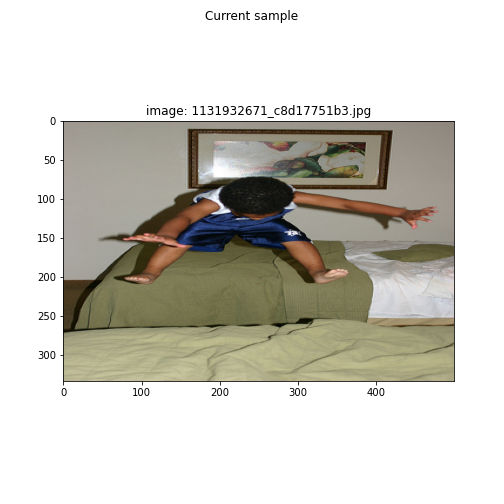

In [185]:
# Create the widgets
left = widgets.Button(description='Left')
right = widgets.Button(description='Right')
out = widgets.Output()

# get the file names
DATA_PATH = 'flickr/Images/'
full_df = pd.read_json('results_comparison.json')

# Setting the first and last indexs
i=0 # starting index
i_max = full_df.shape[0] # ending index

# Plot the first picture
img = plt.imread(f'{DATA_PATH}/{full_df.iloc[i, 0]}')
fig, ax = plt.subplots(1, figsize=(7, 7))
ax = plt.imshow(img)
plt.suptitle("Current sample")
plt.show()
with out:
    clear_output()
    display(full_df.iloc[i:i+1].drop('file_name', axis=1))
    display(calculate_scores(full_df.iloc[i]))

# plots the next image
def plot_next(*args):
    global i
    i += 1
    # stop
    if i >= i_max: 
        print("Done")
        return

    
    # get next image index
    img = plt.imread(f'{DATA_PATH}/{full_df.iloc[i, 0]}')
    ax.set_data(img)
    plt.show()
    plt.title(f"image: {full_df.iloc[i, 0]}")
    with out:
        clear_output()
        display(full_df.iloc[i:i+1].drop('file_name', axis=1))
        display(calculate_scores(full_df.iloc[i]))

def plot_previous(*args):
    global i
    i -= 1
    # stop
    if i < 0: 
        print("Done")
        return

    
    
    # get next image index
    img = plt.imread(f'{DATA_PATH}/{full_df.iloc[i, 0]}')
    ax.set_data(img)
    plt.show()
    plt.title(f"image: {full_df.iloc[i, 0]}")

    with out:
        clear_output()
        display(full_df.iloc[i:i+1].drop('file_name', axis=1))
        display(calculate_scores(full_df.iloc[i]))
    
    
# attaching the buttons to their callback functions         
right.on_click(plot_next)
left.on_click(plot_previous)

# showing the widgets
vb1 = widgets.VBox([right, left])
vb2 = widgets.VBox([out])
widgets.HBox([vb1, vb2])